# Import библиотек

In [ ]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary
from sklearn import metrics

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

# Для повторяемости

In [ ]:
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn

In [ ]:
torch_seed(seed = 42, deterministic = True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Считаем нейронки на:', device)

Считаем нейронки на: cuda


# Набор данных

In [ ]:
train_data = datasets.FashionMNIST(root='./data',
                            train=True,
                            download=True,
                            transform=None)
train_data

100%|██████████| 26421880/26421880 [00:02<00:00, 11990888.36it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204040.23it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3721058.09it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13182098.29it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

## Разбиваем и нормализуем данные

In [ ]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

In [ ]:
print(f'Посчитанное среднее: {mean}')
print(f'Посчитанное СКО: {std}')

Посчитанное среднее: 0.28604060411453247
Посчитанное СКО: 0.35302427411079407


In [ ]:
train_transforms = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.RandomRotation(degrees=10),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

In [ ]:
train_data = datasets.FashionMNIST(root='./data',
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.FashionMNIST(root='./data',
                           train=False,
                           download=True,
                           transform=test_transforms)

In [ ]:
BATCH_SIZE = 128

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                 batch_size=BATCH_SIZE)

# Вспомогательные функции

## Функция подсчета метрики

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

## Функция обучения

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    # обнуляем метрики и функцию потерь
    epoch_loss = 0
    epoch_acc = 0

    # переводим модель в режим обучения
    model.train()

    # перебираем батчи из нашего итератора
    for (x, y) in tqdm(iterator, desc="Учим", leave=False):
        # всё складываем на одно устройстро
        x = x.to(device)
        y = y.to(device)

        # обнуляем градиенты (каждый батч с нового листа)
        optimizer.zero_grad()

        # делаем предсказание текущей модели
        y_pred = model(x)

        # оцениваем функцию потерь
        loss = criterion(y_pred, y)

        # оцениваем метрику
        acc = calculate_accuracy(y_pred, y)

        # тык и посчитали производные
        loss.backward()
        # тык и обновили веса по правилам оптимизатора
        optimizer.step()

        # добавили текущие значения функции потерь и метрики
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        # вернули средние
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Функция оценки

In [ ]:
def evaluate(model, iterator, criterion, device):

    # обнуляем метрики и функцию потерь
    epoch_loss = 0
    epoch_acc = 0

    # переводим модель в режим оценки
    model.eval()
    # даём всем понять что мы не будем считать градиенты. Вообще
    with torch.no_grad():
    # перебираем батчи из нашего итератора
        for (x, y) in tqdm(iterator, desc="Оцениваем", leave=False):
            # всё складываем на одно устройстро
            x = x.to(device)
            y = y.to(device)

            # делаем предсказание текущей модели
            y_pred = model(x)

            # оцениваем функцию потерь
            loss = criterion(y_pred, y)

            # оцениваем метрику
            acc = calculate_accuracy(y_pred, y)

            # добавили текущие значения функции потерь и метрики
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        # вернули средние
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Функция предсказания

In [ ]:
def get_predictions(model, iterator, device):
    # переводим модель в режим оценки
    model.eval()

    images = []
    labels = []
    probs = []

    # даём всем понять что мы не будем считать градиенты. Вообще
    with torch.no_grad():

        for (x, y) in iterator:
            # всё складываем на одно устройстро
            x = x.to(device)

            # делаем предсказание текущей модели
            y_pred = model(x)

            # делаем софт-макс преобразование
            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

# Свёрточная Нейронная сеть

In [ ]:
class NotLeNet(nn.Module):

    def __init__(self, in_channels, n_classes):
        super().__init__()

        self.in_channels = in_channels
        self.n_classes   = n_classes

        # свёртка первая
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels,
                                 out_channels = 6,
                                 kernel_size  = 5)

        # свёртка вторая
        self.conv2   = nn.Conv2d(in_channels  = 6,
                                 out_channels = 16,
                                 kernel_size  = 5)

        # pooling
        self.pool = nn.AvgPool2d(kernel_size = 2,
                                 stride      = 2)

        # полносвязные слои
        #                                   ↓ количество каналов в последнем свёрточном слое
        #                                        ↓ размер того что в конце
        self.fc1 = nn.Linear(in_features  = 16 * 4 * 4,
                             out_features = 16)
        # классификация
        self.fc_out = nn.Linear(in_features = 16,
                                out_features = self.n_classes)

    def flatten(self, x):
        # выпрямление последего свёрточного канала
        return x.view(-1, 16 * 4 * 4)

    def forward(self, x):

        # первый слой
        x = self.conv1(x)
        x = torch.sigmoid(x)
        x = self.pool(x)

        # второй слой
        x = self.conv2(x)
        x = torch.sigmoid(x)
        x = self.pool(x)

        # выпрямление
        x = self.flatten(x)

        # первый полносвязный слой
        x = self.fc1(x)
        x = torch.sigmoid(x)

        # выходной слой
        x = self.fc_out(x)

        return x

## Модель

In [ ]:
LR = 0.001
model_cnn     = NotLeNet(1,10)
criterion = nn.CrossEntropyLoss()
metric    = calculate_accuracy
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=LR)

model_cnn     = model_cnn.to(device)
criterion = criterion.to(device)

In [ ]:
summary(model_cnn,input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         AvgPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         AvgPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                   [-1, 16]           4,112
            Linear-6                   [-1, 10]             170
Total params: 6,854
Trainable params: 6,854
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.03
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


## Обучение

In [ ]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    # обучаем на тренировочных данных
    train_loss, train_acc = train(model_cnn, train_iterator, optimizer, criterion, device)
    # оцениваем на валидационных
    valid_loss, valid_acc = evaluate(model_cnn, test_iterator, criterion, device)

    # сохраняем лучшую модель по потерям на валидационной выборке
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_cnn.state_dict(), 'tut1-model_cnn.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Учим:   0%|          | 0/938 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 1.408 | Train Acc: 55.62%
	 Val. Loss: 0.955 |  Val. Acc: 69.93%


Учим:   0%|          | 0/938 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 0.812 | Train Acc: 72.36%
	 Val. Loss: 0.738 |  Val. Acc: 73.50%


Учим:   0%|          | 0/938 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 34s
	Train Loss: 0.671 | Train Acc: 74.90%
	 Val. Loss: 0.654 |  Val. Acc: 74.94%


Учим:   0%|          | 0/938 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 17s
	Train Loss: 0.604 | Train Acc: 76.91%
	 Val. Loss: 0.599 |  Val. Acc: 76.69%


Учим:   0%|          | 0/938 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 18s
	Train Loss: 0.560 | Train Acc: 78.33%
	 Val. Loss: 0.562 |  Val. Acc: 78.52%


Учим:   0%|          | 0/938 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 17s
	Train Loss: 0.528 | Train Acc: 79.64%
	 Val. Loss: 0.538 |  Val. Acc: 79.08%


Учим:   0%|          | 0/938 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 19s
	Train Loss: 0.502 | Train Acc: 80.50%
	 Val. Loss: 0.510 |  Val. Acc: 79.92%


Учим:   0%|          | 0/938 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 18s
	Train Loss: 0.481 | Train Acc: 81.42%
	 Val. Loss: 0.490 |  Val. Acc: 80.77%


Учим:   0%|          | 0/938 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 18s
	Train Loss: 0.462 | Train Acc: 82.51%
	 Val. Loss: 0.475 |  Val. Acc: 82.09%


Учим:   0%|          | 0/938 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 18s
	Train Loss: 0.447 | Train Acc: 83.39%
	 Val. Loss: 0.462 |  Val. Acc: 82.95%


## Метрики

In [ ]:
test_loss, test_acc = evaluate(model_cnn, test_iterator, criterion, device)
print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}%')

Оцениваем:   0%|          | 0/157 [00:00<?, ?it/s]

	 Val. Loss: 0.462 |  Val. Acc: 82.95%


По метрики достаточно хорошо, посмотрим, как мы предсказываем

## Предсказание

In [ ]:
images, labels, probs = get_predictions(model_cnn, test_iterator, device)
# находим предсказание модели как аргмакс вероятности
pred_labels = torch.argmax(probs, 1)

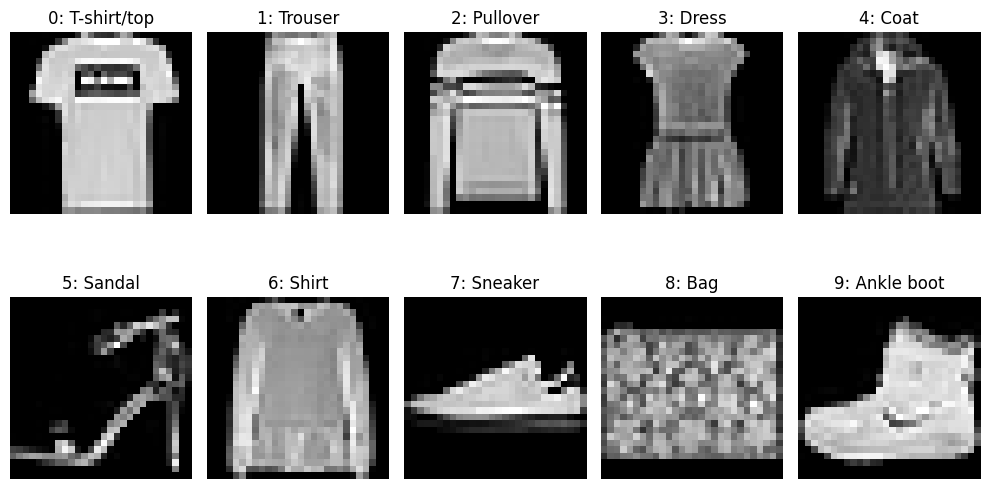

In [ ]:
# здесь, чтобы не запутываться в матрице, решил рассмотреть, как выглядят примеры данных, и понять, что мы с чем путаем
train_data = datasets.FashionMNIST(root='./data',
                            train=True,
                            download=True,
                            transform=None)
# основные классы изоображений
class_names = ['0: T-shirt/top', '1: Trouser', '2: Pullover', '3: Dress', '4: Coat',
               '5: Sandal', '6: Shirt', '7: Sneaker', '8: Bag', '9: Ankle boot']
fig, axes = plt.subplots(2, 5, figsize=(10, 6))
axes = axes.flatten()

# выводим все 10
for i in range(10):
    for image, label in train_data:
        if label == i:
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(class_names[i])
            axes[i].axis('off')
            break

plt.tight_layout()
plt.show()

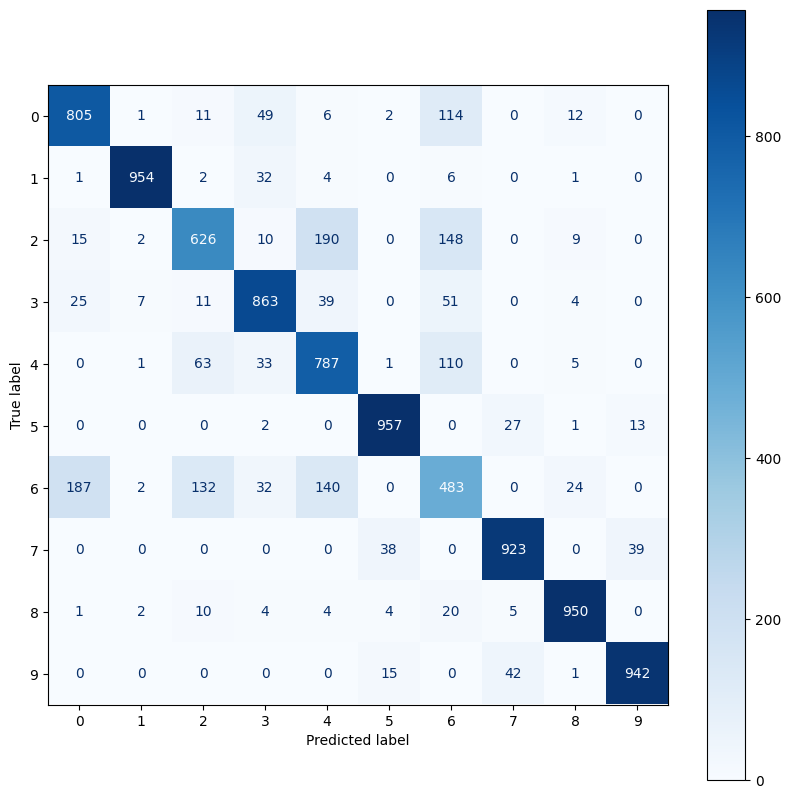

In [ ]:
# что с чем путаем
plot_confusion_matrix(labels, pred_labels)

Небольшие выводы:
* большая проблема это рубашки (класс 6), их путаем очень сильно
  * с пальто (класс 4) - тут говорить нечего, они просто идентичны, только разницы в застежках
  * со свитерами (класс 2) - тут тоже форма одинаковая
  * с футболками (класс 0) - тут надо отдельно посмотреть, странно ведь есть сильная разница в рукавах
* также путаем пальто (класс 4) со свитерами (класс 2) - впринципе они очень похожи по форме
* из хорошего - особо сильно не путаем различную обувь между сообой (классы 5,7,9)
* также почти идеально предсказываем брюки (класс 1), только немного путаем с платьем, но там форма почти похожа

### Предсказание в деталях

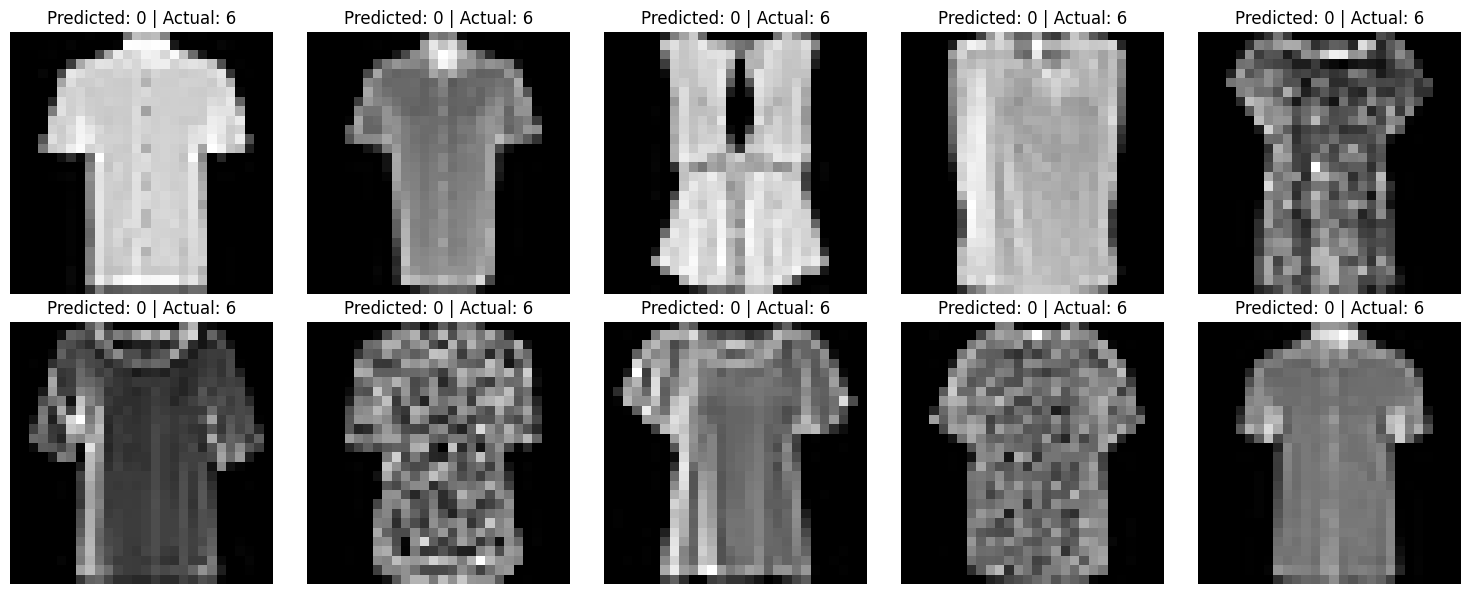

In [ ]:
# Посмотрим почему мы рубашкам предсказываем класс футболки

misclassified_examples = []

for i in range(len(labels)):
    # Если модель предсказала метку 0, а фактическая метка равна 6
    if pred_labels[i] == 0 and labels[i] == 6:
        misclassified_examples.append(i)
        # Посмотрим 10 примеров
        if len(misclassified_examples) == 10:
            break

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for idx, ax in zip(misclassified_examples, axs.flat):
    ax.imshow(images[idx].squeeze(), cmap='gray')
    ax.axis('off')
    # Выводим предсказанную и фактическую метки
    ax.set_title(f'Predicted: {pred_labels[idx]} | Actual: {labels[idx]}')

plt.tight_layout()
plt.show()

Ну тут и на взгляд трудно понять, что это не футболки, а рубашки

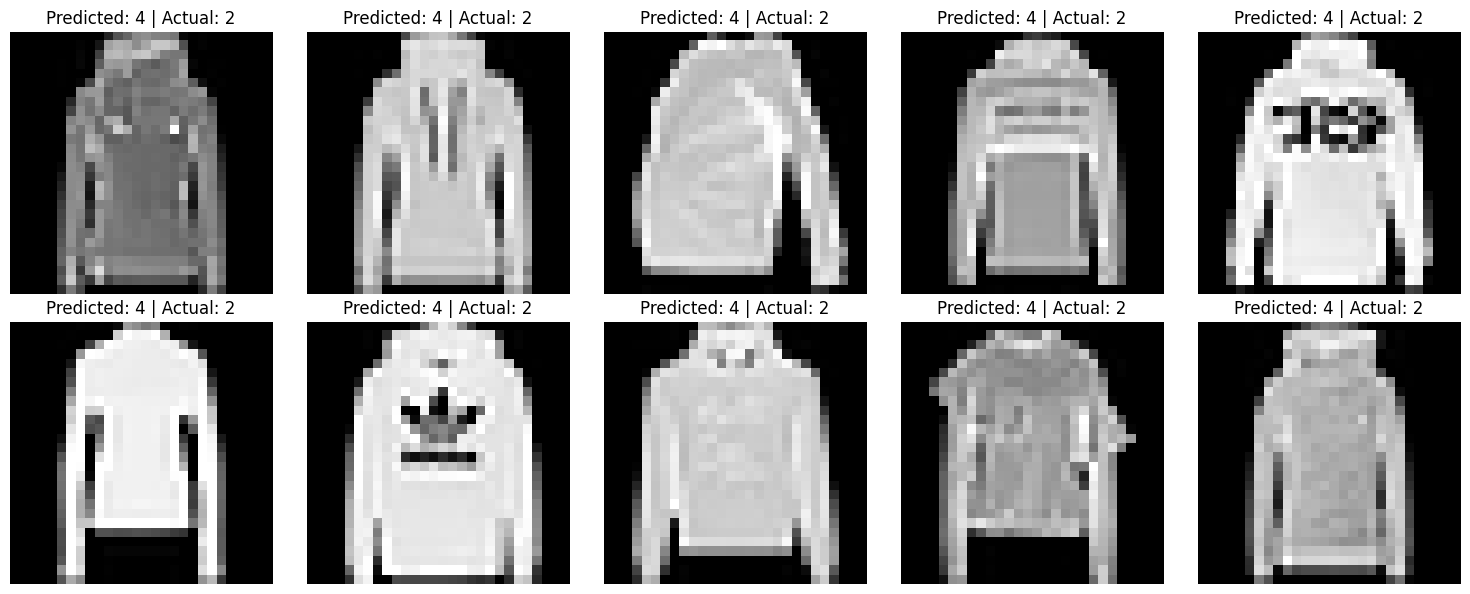

In [ ]:
# Посмотрим почему мы свитерам предсказываем класс пальто

misclassified_examples = []

for i in range(len(labels)):
    # Если модель предсказала метку 4, а фактическая метка равна 2
    if pred_labels[i] == 4 and labels[i] == 2:
        misclassified_examples.append(i)
        # Посмотрим 10 примеров
        if len(misclassified_examples) == 10:
            break

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for idx, ax in zip(misclassified_examples, axs.flat):
    ax.imshow(images[idx].squeeze(), cmap='gray')
    ax.axis('off')
    # Выводим предсказанную и фактическую метки
    ax.set_title(f'Predicted: {pred_labels[idx]} | Actual: {labels[idx]}')

plt.tight_layout()
plt.show()

Вроде не совсем похоже на пальто, посмотрим отдельно как выглядят наши пальто в датасете

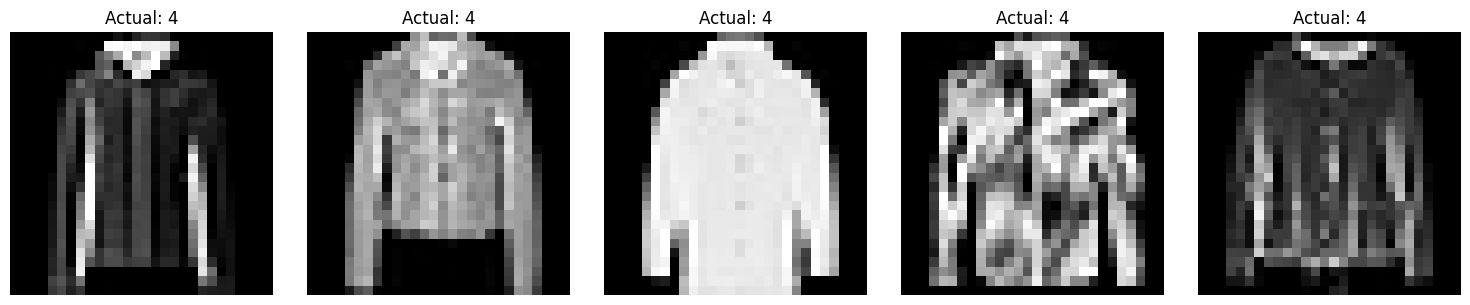

In [ ]:
class_4_examples = []

# Проходимся по всем примерам
for i in range(len(labels)):
    if labels[i] == 4:
        class_4_examples.append(i)
        if len(class_4_examples) == 5:
            break

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Выводим примеры класса 4
for idx, ax in zip(class_4_examples, axs.flat):
    ax.imshow(images[idx].squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Actual: {labels[idx]}')

plt.tight_layout()
plt.show()

Теперь становится уже яснее, видимо это собирательное название (пальто)

Выглядят они очень идентично с классом 2 (свитера)

# Пробуем улучшить модель

## Модель

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
class SimpleLeNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(SimpleLeNet, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes

        self.conv1 = nn.Conv2d(in_channels=self.in_channels,
                               out_channels=64,
                               kernel_size=3,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(in_channels=128,
                               out_channels=256,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(in_channels=256,
                               out_channels=256,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=9216, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=1028)
        self.fc3 = nn.Linear(in_features=1028, out_features=self.n_classes)

        self.dropout = nn.Dropout(0.2)

        #self.prelu = nn.PReLU()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        #x = self.prelu(self.bn1(self.conv1(x)))
        #x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        #x = self.prelu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        #x = self.prelu(self.bn3(self.conv3(x)))
        #x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        #x = self.prelu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        #x = self.fc3(x)
        #x = F.relu(self.fc3(x))
        #x = self.dropout(x)
        #x = F.relu(self.fc4(x))
        return x

LR = 0.001
model_simple = SimpleLeNet(1, 10)
criterion = nn.CrossEntropyLoss()

metric = calculate_accuracy
optimizer = torch.optim.RAdam(model_simple.parameters(), lr=LR, weight_decay=1e-4)
#optimizer = torch.optim.Adam(model_simple.parameters(), lr=LR, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

model = model_simple.to(device)
criterion = criterion.to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
       BatchNorm2d-2           [-1, 64, 26, 26]             128
            Conv2d-3          [-1, 128, 26, 26]          73,856
       BatchNorm2d-4          [-1, 128, 26, 26]             256
         MaxPool2d-5          [-1, 128, 13, 13]               0
            Conv2d-6          [-1, 256, 13, 13]         295,168
       BatchNorm2d-7          [-1, 256, 13, 13]             512
            Conv2d-8          [-1, 256, 13, 13]         590,080
       BatchNorm2d-9          [-1, 256, 13, 13]             512
        MaxPool2d-10            [-1, 256, 6, 6]               0
           Linear-11                 [-1, 4096]      37,752,832
          Dropout-12                 [-1, 4096]               0
           Linear-13                 [-1, 1028]       4,211,716
          Dropout-14                 [-

## Обучение

In [ ]:
EPOCHS = 10

train_losses = []
valid_losses = []

train_accuracy = []
val_accuracy = []

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, test_iterator, criterion, device)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_accuracy.append(train_acc)
    val_accuracy.append(valid_acc)

    scheduler.step(valid_loss)
    current_lr = scheduler.get_last_lr()[0]

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model_cnn.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print(f'\t Current LR: {current_lr:.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]

Учим:   0%|          | 0/469 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 20s
	Train Loss: 0.483 | Train Acc: 82.67%
	 Val. Loss: 0.298 |  Val. Acc: 89.31%
	 Current LR: 0.0010


Учим:   0%|          | 0/469 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 18s
	Train Loss: 0.295 | Train Acc: 89.17%
	 Val. Loss: 0.254 |  Val. Acc: 90.50%
	 Current LR: 0.0010


Учим:   0%|          | 0/469 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 16s
	Train Loss: 0.261 | Train Acc: 90.42%
	 Val. Loss: 0.251 |  Val. Acc: 90.74%
	 Current LR: 0.0010


Учим:   0%|          | 0/469 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 16s
	Train Loss: 0.234 | Train Acc: 91.57%
	 Val. Loss: 0.242 |  Val. Acc: 91.29%
	 Current LR: 0.0010


Учим:   0%|          | 0/469 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 17s
	Train Loss: 0.219 | Train Acc: 92.07%
	 Val. Loss: 0.213 |  Val. Acc: 92.32%
	 Current LR: 0.0010


Учим:   0%|          | 0/469 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 18s
	Train Loss: 0.207 | Train Acc: 92.45%
	 Val. Loss: 0.268 |  Val. Acc: 90.56%
	 Current LR: 0.0010


Учим:   0%|          | 0/469 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 17s
	Train Loss: 0.200 | Train Acc: 92.82%
	 Val. Loss: 0.198 |  Val. Acc: 92.82%
	 Current LR: 0.0010


Учим:   0%|          | 0/469 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 17s
	Train Loss: 0.192 | Train Acc: 93.12%
	 Val. Loss: 0.233 |  Val. Acc: 91.76%
	 Current LR: 0.0010


Учим:   0%|          | 0/469 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 17s
	Train Loss: 0.184 | Train Acc: 93.30%
	 Val. Loss: 0.214 |  Val. Acc: 92.14%
	 Current LR: 0.0010


Учим:   0%|          | 0/469 [00:00<?, ?it/s]

Оцениваем:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 17s
	Train Loss: 0.179 | Train Acc: 93.59%
	 Val. Loss: 0.197 |  Val. Acc: 93.31%
	 Current LR: 0.0010


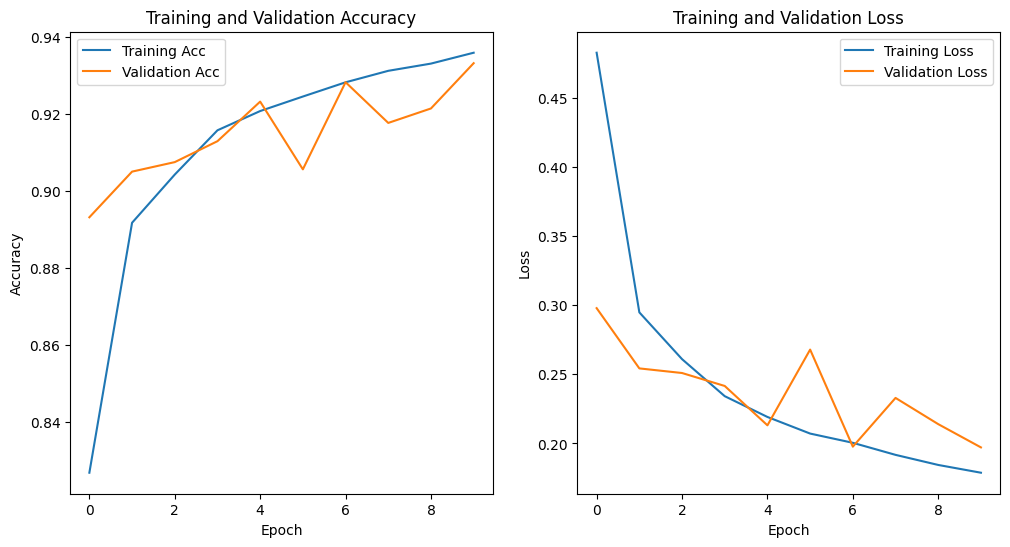

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(train_accuracy, label='Training Acc')
ax1.plot(val_accuracy, label='Validation Acc')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.legend()

ax2.plot(train_losses, label='Training Loss')
ax2.plot(valid_losses, label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()

plt.show()

## Метрики

In [ ]:
loaded_model = SimpleLeNet(1,10)
loaded_model.to(device)
loaded_model.load_state_dict(torch.load('tut1-model_cnn.pt'))

test_loss, test_acc = evaluate(loaded_model, test_iterator, criterion, device)
print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}%')

Оцениваем:   0%|          | 0/79 [00:00<?, ?it/s]

	 Val. Loss: 0.197 |  Val. Acc: 93.31%


## Предсказание

In [ ]:
images, labels, probs = get_predictions(loaded_model, test_iterator, device)
# находим предсказание модели как аргмакс вероятности
pred_labels = torch.argmax(probs, 1)

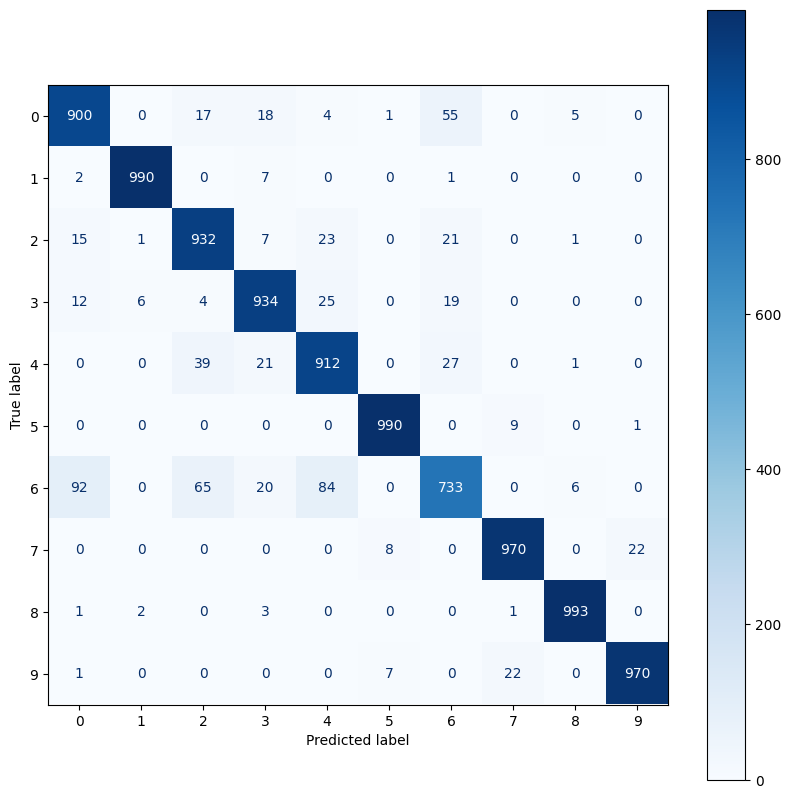

In [ ]:
# что с чем путаем
plot_confusion_matrix(labels, pred_labels)

Небольшие выводы:
* проблемы остались примерно те же
* до сих пор путаем рубашки (класс 6), но уже не так сильно:
  * с пальто (класс 4) - ну они одной формы
  * с футболками (класс 0) - смотрели, там все одинаково
* также путаем пальто (класс 4) со свитерами (класс 2) - впринципе они очень похожи по форме
* из хорошего - остальные классы почти не путаем, много нулей

### Посмотрим детально

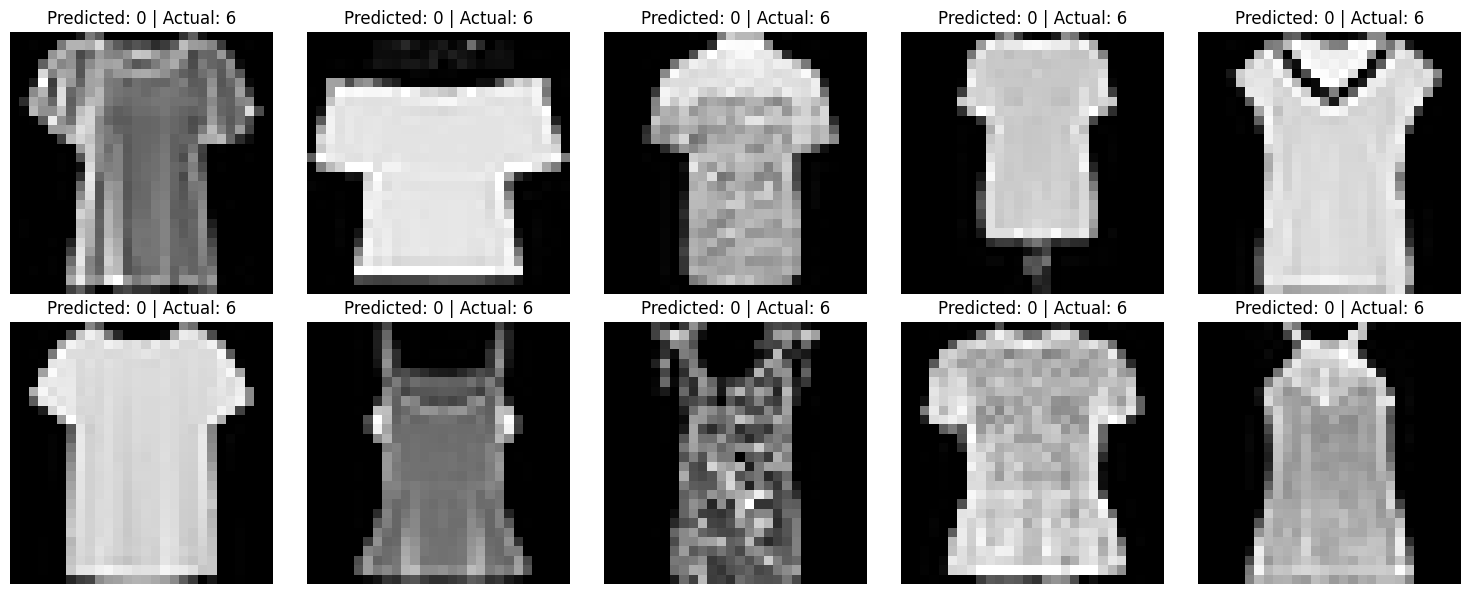

In [ ]:
# Посмотрим почему мы рубашкам предсказываем класс футболки

misclassified_examples = []

for i in range(len(labels)):
    # Если модель предсказала метку 0, а фактическая метка равна 6
    if pred_labels[i] == 0 and labels[i] == 6:
        misclassified_examples.append(i)
        # Посмотрим 10 примеров
        if len(misclassified_examples) == 10:
            break

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for idx, ax in zip(misclassified_examples, axs.flat):
    ax.imshow(images[idx].squeeze(), cmap='gray')
    ax.axis('off')
    # Выводим предсказанную и фактическую метки
    ax.set_title(f'Predicted: {pred_labels[idx]} | Actual: {labels[idx]}')

plt.tight_layout()
plt.show()

Ну это не честно, это не рубашки/свитшоты, тут половина платья, футболки. Половину не отличишь от 0 класса (футболки), но остальная часть это другое

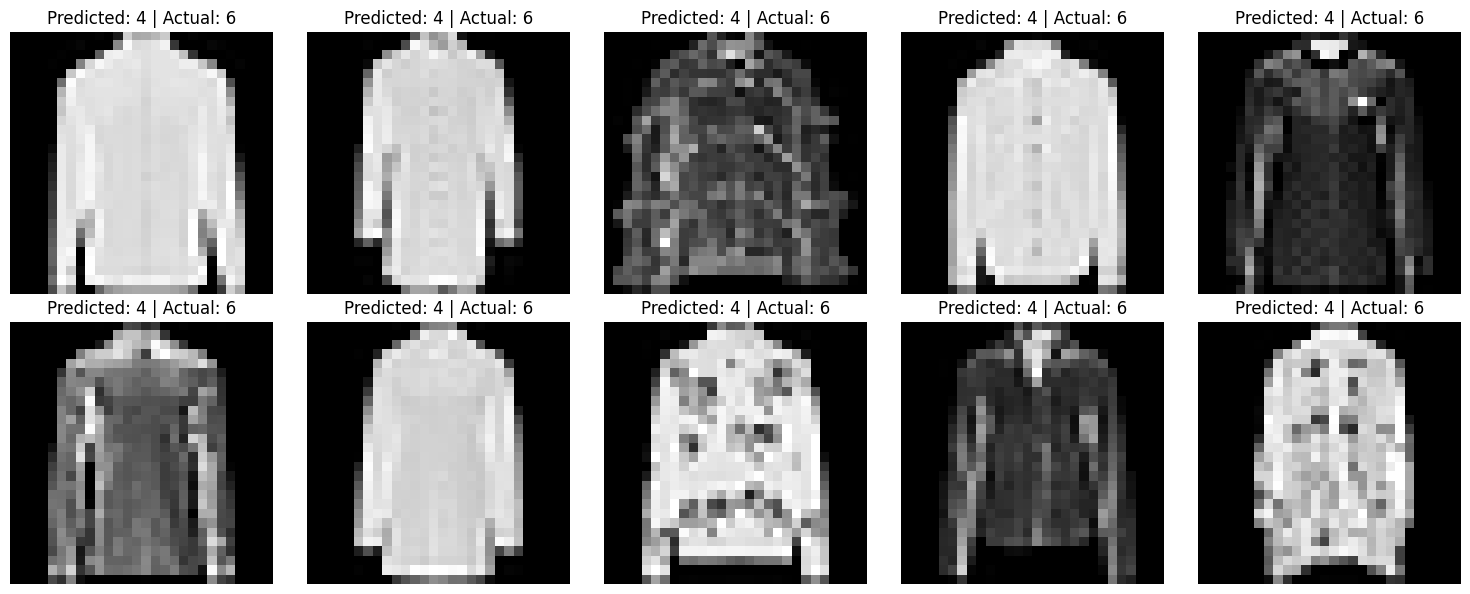

In [ ]:
# Посмотрим почему мы рубашкам предсказываем класс пальто

misclassified_examples = []

for i in range(len(labels)):
    # Если модель предсказала метку 4, а фактическая метка равна 6
    if pred_labels[i] == 4 and labels[i] == 6:
        misclassified_examples.append(i)
        # Посмотрим 10 примеров
        if len(misclassified_examples) == 10:
            break

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for idx, ax in zip(misclassified_examples, axs.flat):
    ax.imshow(images[idx].squeeze(), cmap='gray')
    ax.axis('off')
    # Выводим предсказанную и фактическую метки
    ax.set_title(f'Predicted: {pred_labels[idx]} | Actual: {labels[idx]}')

plt.tight_layout()
plt.show()

Ну тут есть рубашки похожие на пальто, но в целом, да, путаем пальто с рубашками

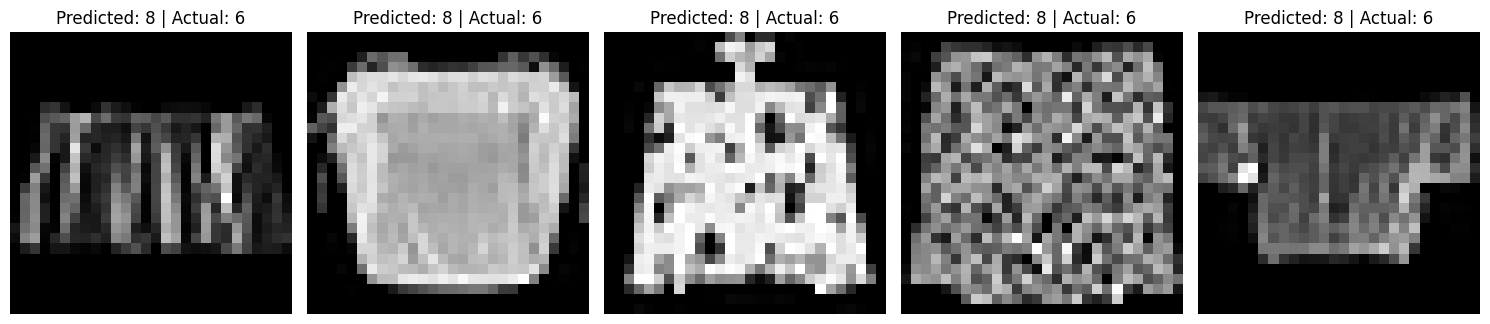

In [ ]:
# Посмотрим почему мы рубашкам предсказываем класс сумку (как бы это сранно не звучало)

misclassified_examples = []

for i in range(len(labels)):
    # Если модель предсказала метку 8, а фактическая метка равна 6
    if pred_labels[i] == 8 and labels[i] == 6:
        misclassified_examples.append(i)
        # Посмотрим 10 примеров
        if len(misclassified_examples) == 5:
            break

fig, axs = plt.subplots(1, 5, figsize=(15, 6))

for idx, ax in zip(misclassified_examples, axs.flat):
    ax.imshow(images[idx].squeeze(), cmap='gray')
    ax.axis('off')
    # Выводим предсказанную и фактическую метки
    ax.set_title(f'Predicted: {pred_labels[idx]} | Actual: {labels[idx]}')

plt.tight_layout()
plt.show()

Тут вообще не понимаю, почему мы этим сумкам предсказываем рубашки

# Выводы

Как добился метрики:
* метрика получилась не супер хорошой как просилось (0.93 вместо 0.97)
* пробовал разные функции активации - выяснил, что сигмоида и tanh не очень тут, relu топ, пробовал разные вариации relu, но обычная оказалась лучше всех
* функция оптимизации RAdam оказалась лучше, чем Adam
* maxpool, batchnorm и dropout помогли поднять метрику
* из всех моих вариантов 4 свертки и 3 полносвязки были лучшей структурой
* еще пробовал играться с нейронами, на полносвязных слоях, когда в конце много нейронов, получался результат лучше
* попробовал ReduceLROnPlateau, но видимо не так сильно дало результата
* также покрутил картинки, что дало увеличение метрики